# End to end First Machine Learning Project

## Install the Azure ML SDK for Python and Authentication to Azure

In [47]:
#!pip install azureml.core

import azureml.core
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.19.0


In [48]:
from azureml.core import authentication

auth = authentication.InteractiveLoginAuthentication()
print('Signed in')

Signed in


## Read in config file
This saved configuration file enables you to easily obtain a reference to the workspace by simply loading it, as demonstrated in the following cell. Note that this method will prompt you to reauthenticate against your Azure subscription if your session has expired.

In [49]:
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to work with', ws.name)

Ready to work with amlworkspacesahiep2141


# Run your first Experiment

Starting experiment: diabetes-experiment


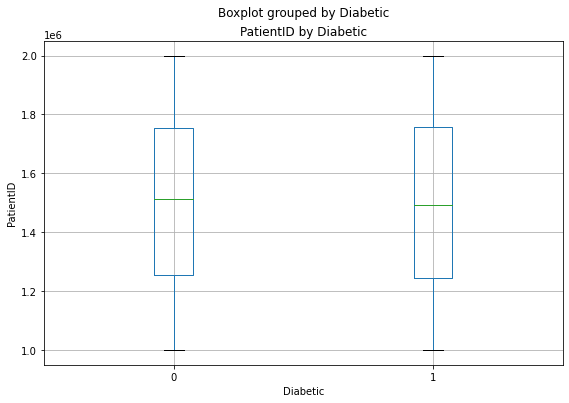

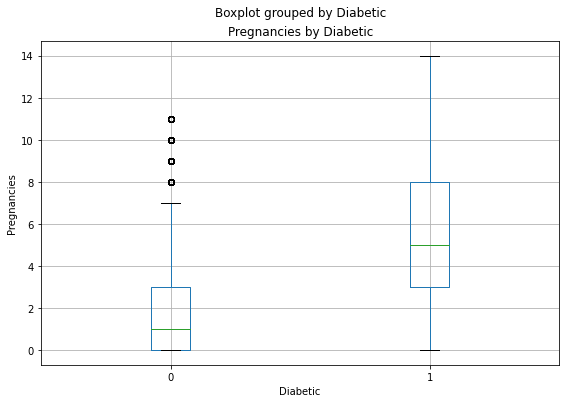

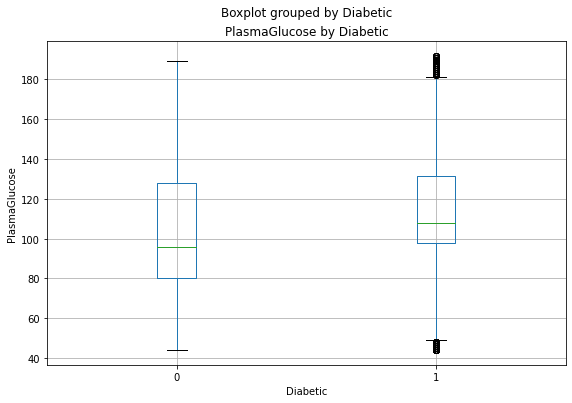

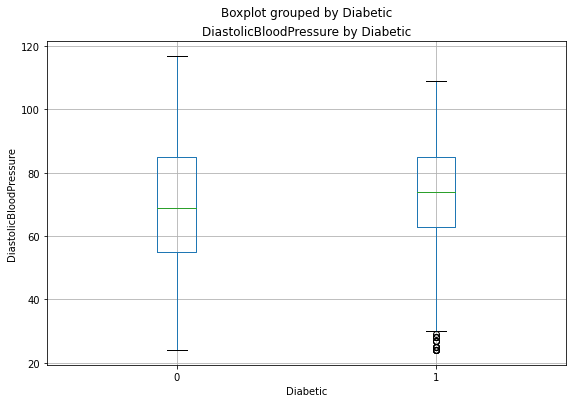

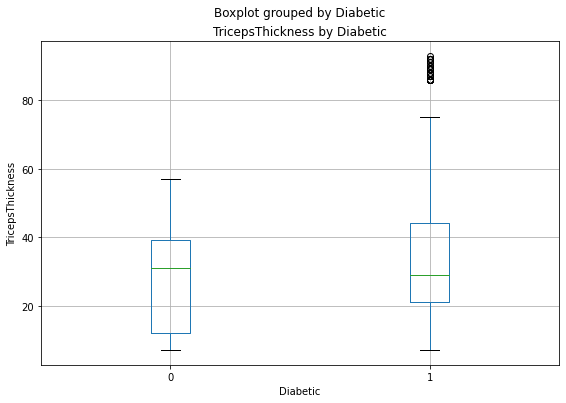

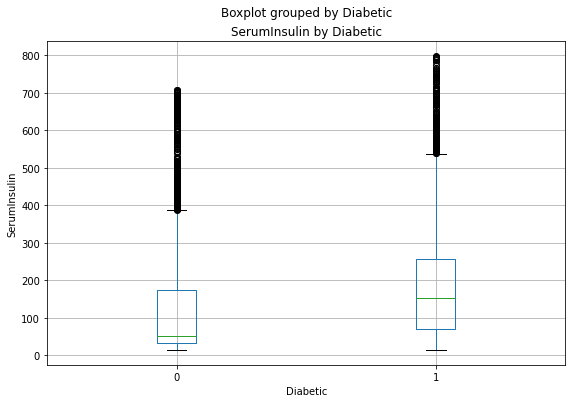

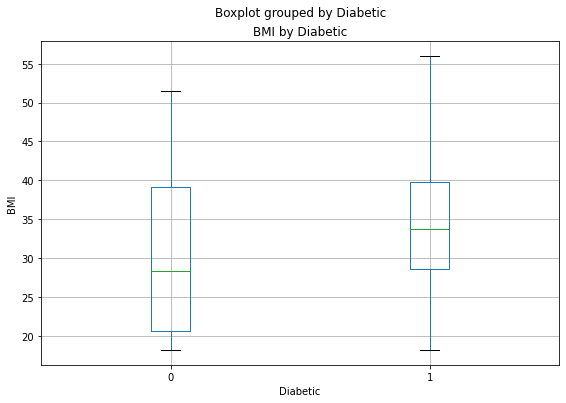

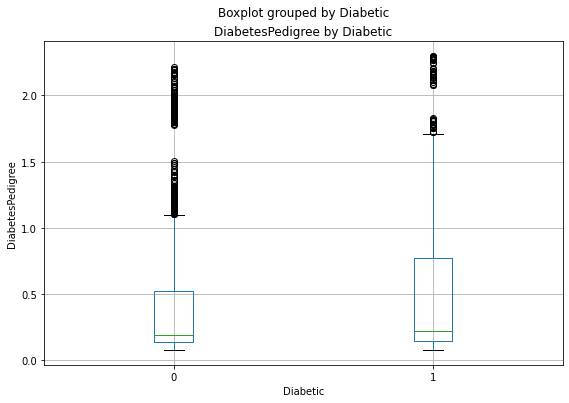

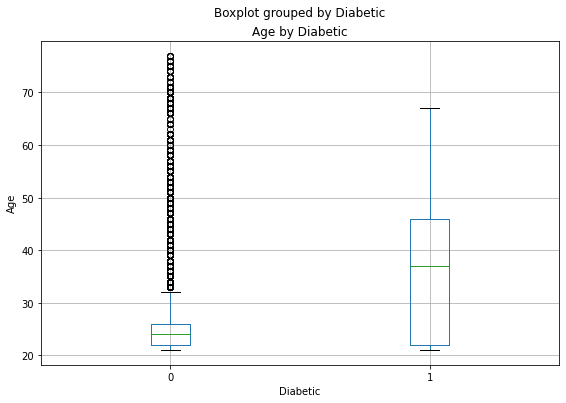

In [50]:
from azureml.core import Experiment, Run
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace = ws, name = "diabetes-experiment")
print("Starting experiment:", experiment.name)

# Start logging data from the experiment
run = experiment.start_logging()

# load the diabetes dataset
data = pd.read_csv('./data/diabetes.csv')


# Count the rows and log the result
row_count = (len(data))
run.log("observations", row_count)

# Create box plots for each feature variable by the "diabetic" label and log them
num_cols = data.columns[:-1]
for col in num_cols:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    data.boxplot(column = col, by = "Diabetic", ax = ax)
    ax.set_title(col + ' by Diabetic')
    ax.set_ylabel(col)
    run.log_image(name = col, plot = fig)
plt.show()

# Create a list of mean diabetes pedigree per age and log it
mean_by_age = data[["Age", "DiabetesPedigree"]].groupby(["Age"]).mean().reset_index()
ages = mean_by_age["Age"].tolist()
pedigrees = mean_by_age["DiabetesPedigree"].tolist()
for index in range(len(ages)):
       run.log_row("Mean Diabetes Pedigree by Age", Age = ages[index],Diabetes_Pedigree = pedigrees[index])

# Save a sample of the data and upload it to the experiment output
data.sample(100).to_csv("sample.csv", index=False, header=True)
run.upload_file(name = 'outputs/sample.csv', path_or_stream = './sample.csv')

# Complete tracking and get link to details
run.complete()

In [51]:
# View Experiment Result
run

Experiment,Id,Type,Status,Details Page,Docs Page
diabetes-experiment,cd251c38-68a7-43d6-be8c-f1d3c1f10c5a,,Running,Link to Azure Machine Learning studio,Link to Documentation


# Upload Data to your datastore

In [52]:
from azureml.core import Datastore

# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name)

azureml_globaldatasets - Default = False
sqlpool01 - Default = False
workspacefilestore - Default = False
workspaceblobstore - Default = True


In [53]:
default_ds.upload_files(files=['./data/diabetes.csv'], # Upload the data/diabetes.csv file
                       target_path='diabetes-data/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

UserErrorException: UserErrorException:
	Message: './data/diabetes.csv' does not point to a file. Please upload the file to cloud first if running in a cloud notebook.
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "'./data/diabetes.csv' does not point to a file. Please upload the file to cloud first if running in a cloud notebook."
    }
}

## Create and Register a Dataset

In [38]:
from azureml.core import Dataset

#Create a tabular dataset from the path on the datastore (this may take a short while)
data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'diabetes-data/diabetes.csv'))

# Display the first 20 rows as a Pandas dataframe
data_set.take(20).to_pandas_dataframe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
5,1619297,0,82,92,9,253,19.724160,0.103424,26,0
6,1660149,0,133,47,19,227,21.941357,0.174160,21,0
7,1458769,0,67,87,43,36,18.277723,0.236165,26,0
8,1201647,8,80,95,33,24,26.624929,0.443947,53,1
9,1403912,1,72,31,40,42,36.889576,0.103944,26,0


In [39]:
# Register the dataset
dataset_name = 'Diabetes Dataset'
data_set = data_set.register(workspace=ws, 
                           name=dataset_name,
                           description='diabetes data',
                           tags = {'year':'2019', 'category':'Diabetes'},
                           create_new_version=True)

# List the datasets registered in the workspace
for ds in ws.datasets:
    print(ds)

Diabetes Dataset
asaworkspacesahiep2141-saleconsolidated-20210111020231-dataset
pcadata
AggregatedProductSeasonality


## Run an Experiment on Remote Compute

In [40]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # Create an AzureMl Compute resource (a container cluster)
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', 
                                                           vm_priority='dedicated', 
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [41]:
for target_name in ws.compute_targets:
    target = ws.compute_targets[target_name]
    print(target.name, target.type)

devvmsh2141 ComputeInstance
automlcluster AmlCompute
cpu-cluster AmlCompute


In [42]:
import os
from azureml.core import Experiment

# Create an experiment
experiment_name = 'diabetes_training'
experiment = Experiment(workspace = ws, name = experiment_name)

# Create a folder for the experiment files
experiment_folder = './' + experiment_name
os.makedirs(experiment_folder, exist_ok=True)

print("Experiment:", experiment.name)

Experiment: diabetes_training


## Create Training Script

In [43]:
%%writefile $experiment_folder/diabetes_training.py
# Import libraries
import argparse
from azureml.core import Workspace, Dataset, Experiment, Run
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Set regularization parameter
parser = argparse.ArgumentParser()
parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01, help='regularization rate')
args = parser.parse_args()
reg = args.reg_rate

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
dataset_name = 'Diabetes Dataset'
print("Loading data from " + dataset_name)
diabetes = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()

# Separate features and labels
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a logistic regression model
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
run.log_image(name = "ROC", plot = fig)
plt.show()

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/diabetes_model.pkl')

run.complete()

Writing ./diabetes_training/diabetes_training.py


## Submit Training Run

In [44]:
from azureml.train.sklearn import SKLearn

# Set the script parameters
script_params = {
    '--regularization': 0.1
}


# Create a new estimator that uses the remote compute
remote_estimator = SKLearn(source_directory=experiment_folder,
                           script_params=script_params,
                           compute_target = cpu_cluster,
                           conda_packages=['pandas','ipykernel','matplotlib'],
                           pip_packages=['azureml-sdk','argparse','pyarrow'],
                           entry_script='diabetes_training.py')

# Run the experiment
run = experiment.submit(config=remote_estimator)
run.wait_for_completion(show_output=True)


ml_0aaf110227fc8460da3fec9a83981489/lib/python3.6/site-packages (from azureml-core~=1.20.0->azureml-sdk->-r /azureml-environment-setup/condaenv.8resk8ar.requirements.txt (line 1)) (2020.1)
  Created wheel for json-logging-py: filename=json_logging_py-0.2-py3-none-any.whl size=3924 sha256=cf218d84655c9a519c09a6c5b610c61ac904c9e6507f8dfb99f03b3dd76a967e
  Stored in directory: /root/.cache/pip/wheels/e2/1d/52/535a274b9c2ce7d4064838f2bdb62013801281ef7d7f21e2ee
  Created wheel for fusepy: filename=fusepy-3.0.1-py3-none-any.whl size=10504 sha256=e9f8480663f82e49d1acfbe8d3c23c1da8e067579ceedebd2a931d00e36af8df
  Stored in directory: /root/.cache/pip/wheels/21/5c/83/1dd7e8a232d12227e5410120f4374b33adeb4037473105b079
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11730 sha256=b503c53843f7c88f5978edd5bb1ea26be5fd6dfdcfa6339810579e12292c72bc
  Stored in directory: /root/.cache/pip/wheels/53/ba/da/8562a6a6dbb428fd1ecc21053106df3948645cd991958f669b
Successfully built 

{'runId': 'diabetes_training_1611502272_ce048a88',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-01-24T15:44:34.802874Z',
 'endTimeUtc': '2021-01-24T15:47:19.640189Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '7fa21f1f-b31a-49ad-bd5a-c15a1e9a912c',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '47bce42a-e0eb-417d-a16c-79be8c6e0070'}, 'consumptionDetails': {'type': 'Reference'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--regularization', '0.1'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'priority': None,
  'credentialP

In [45]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
diabetes_training,diabetes_training_1611502272_ce048a88,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Register Model

In [46]:
from azureml.core import Model

# Register model
run.register_model(model_path='outputs/diabetes_model.pkl', model_name='diabetes_model', tags={'Training context':'remote compute'}, properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

# List registered models
for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 1
	 Training context : remote compute
	 AUC : 0.8568595320655352
	 Accuracy : 0.7891111111111111


resnet50 version: 7
	 area : Image classification
	 type : classification


resnet50 version: 6
	 area : Image classification
	 type : classification


resnet50 version: 4
	 area : Image classification
	 type : classification


resnet50 version: 2
	 area : Image classification
	 type : classification


resnet50 version: 1
	 area : Image classification
	 type : classification


asaworkspacesahiep2141-saleconsolidated-20210111020231-Best version: 1
	 azureml.artifactPrefix : ExperimentRun/dcid.3f605d22-0375-4be5-9c08-657240cc6125/asaworkspacesahiep2141-saleconsolidated-20210111020231_artifact
	 mlflow.modelSourceUri : azureml://experiments/asaworkspacesahiep2141-saleconsolidated-20210111020231/runs/3f605d22-0375-4be5-9c08-657240cc6125/artifacts/asaworkspacesahiep2141-saleconsolidated-20210111020231_artifact




## Deploy a Model as a Web Service

In [ ]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

In [ ]:
model = ws.models['diabetes_model']
print(model.name, 'version', model.version)

In [ ]:
import os

folder_name = 'diabetes_service'

# Create a folder for the web service files
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

print(folder_name, 'folder created.')

## Create Scoring Script 

In [ ]:
%%writefile $folder_name/score_diabetes.py
import json
import numpy as np
import os
import joblib
from azureml.core.model import Model
import azureml.train.automl # Required for AutoML models

# Called when the service is loaded
def init():
    global model
    # Get the path to the deployed model file and load it
    model_path = Model.get_model_path('diabetes_model')
    model = joblib.load(model_path)

# Called when a request is received
def run(raw_data):
    # Get the input data - the features of patients to be classified.
    data = json.loads(raw_data)['data']
    # Get a prediction from the model
    predictions = model.predict(data)
    # Get the corresponding classname for each prediction (0 or 1)
    classnames = ['not-diabetic', 'diabetic']
    predicted_classes = []
    for prediction in predictions:
        predicted_classes.append(classnames[prediction])
    # Return the predictions as JSON
    return json.dumps(predicted_classes)

In [ ]:
from azureml.core.conda_dependencies import CondaDependencies 

# Add the dependencies for our model (AzureML defaults is already included)
myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")
myenv.add_pip_package("azureml-sdk[automl]") # Required for AutoML models

# Save the environment config as a .yml file
env_file = folder_name + "/diabetes_env.yml"
with open(env_file,"w") as f:
    f.write(myenv.serialize_to_string())
print("Saved dependency info in", env_file)

# Print the .yml file
with open(env_file,"r") as f:
    print(f.read())

## Deploy Model to ACI

In [ ]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig

# Configure the scoring environment
inference_config = InferenceConfig(runtime= "python",
                                   source_directory = folder_name,
                                   entry_script="score_diabetes.py",
                                   conda_file="diabetes_env.yml")

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)

service_name = "diabetes-service"

service = Model.deploy(ws, service_name, [model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)

In [ ]:
for webservice_name in ws.webservices:
    webservice = ws.webservices[webservice_name]
    print(webservice.name)

In [ ]:
endpoint = service.scoring_uri
print(endpoint)

In [ ]:
import json

# This time our input is an array of two feature arrays
x_new = [[2,180,74,24,21,23.9091702,1.488172308,22],
         [0,148,58,11,179,39.19207553,0.160829008,45]]

# Convert the array or arrays to a serializable list in a JSON document
input_json = json.dumps({"data": x_new})

# Call the web service, passing the input data
predictions = service.run(input_data = input_json)

# Get the predicted classes.
predicted_classes = json.loads(predictions)
   
for i in range(len(x_new)):
    print ("Patient {}".format(x_new[i]), predicted_classes[i] )